### The following code can be used to reconstruct figure 4 (top row) in the paper.

In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, ConstantScaling
from utils import get_config

from plotting import cart2pol 

from mixing_functions import build_moebius_transform, build_automorphism

### Get train/test data and parameters of the Möbius transformation

In [2]:
number_darmois = '0308'
model_root_darmois = '/Users/luigigresele/Desktop/ICA and ICM/Experiments_Vincent/'+ number_darmois +'/projects/ica-flows/experiments/triresflow/2d/'+ number_darmois +'/'

config_darmois = get_config(model_root_darmois + 'config/config.yaml')

In [3]:
S_train = jnp.array(jnp.load(model_root_darmois + 'data/sources_train.npy'))
S_test = jnp.array(jnp.load(model_root_darmois + 'data/sources_test.npy'))
X_train = jnp.array(jnp.load(model_root_darmois + 'data/observation_train.npy'))
X_test = jnp.array(jnp.load(model_root_darmois + 'data/observation_test.npy'))
mean_std = jnp.load(model_root_darmois + 'data/observation_mean_std.npy', allow_pickle=True).item()
mean_train, std_train = mean_std['mean'], mean_std['std']
moeb_params = jnp.load(model_root_darmois + 'data/moebius_transform_params.npy', allow_pickle=True).item()

### Specify how many datapoints to use for the plots and re-define the train/test splits accordingly

In [4]:
howmany = 5000

S_train = S_train[:howmany]
S_test = S_test[:howmany]
X_train = X_train[:howmany]
X_test = X_test[:howmany]

### Define the true mixing and unmixing, based on the parameters.

In [5]:
alpha = 1.0
A = jnp.array(moeb_params['A'])
a = jnp.array(moeb_params['a'])
b = jnp.zeros(2) 

mixing_moebius, mixing_moebius_inv = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = jax.vmap(mixing_moebius)

In [6]:
import matplotlib.pyplot as plt

def scatterplot_variables(X, title, colors='None', cmap='hsv'):
    '''
    Scatterplot of 2d variables, can be used both for the mixing and the unmixing
    X : (N,D) array -- N samples, D dimensions (D=2).ss
    '''
    if colors=='None':
        plt.scatter(X[:,0], X[:,1], color='r', s=30)
    else:
        plt.scatter(X[:,0], X[:,1], c=colors, s=30, alpha=0.75, cmap=cmap)

    plt.axis('off')
    plt.gca().set_aspect('equal', adjustable='box')

### Path where figures should be saved.

In [7]:
import os

figure_path = "/Users/luigigresele/Documents/Plots_IMA"#/perceptually_uniform"

### Colormap for the plots.

In [8]:
cmap = 'hsv'

# Uncomment for perceptually uniform colormaps
# import cmocean
# cmap = cmocean.cm.phase 

_, colors_train = cart2pol(S_train[:, 0], S_train[:, 1])
_, colors_test = cart2pol(S_test[:, 0], S_test[:, 1])

### 1. Plot ground truth sources

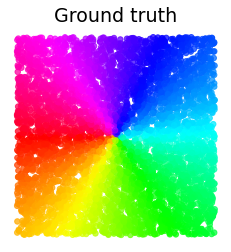

In [9]:
scatterplot_variables(S_test, 'Sources (test)',
                      colors=colors_test, cmap=cmap)


plt.title('Ground truth', fontsize=19)

# Uncomment if you want to save the figure

# fname = os.path.join(figure_path, "true_sources.pdf")
# plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)

plt.show()

### 2. Plot the observations

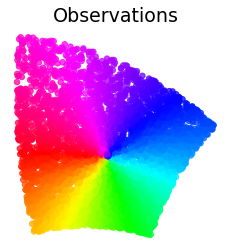

In [10]:
scatterplot_variables(X_test, 'Observations (test)',
                      colors=colors_test, cmap=cmap)

plt.title('Observations', fontsize=19)

# Uncomment if you want to save the figure

# fname = os.path.join(figure_path, "observations.pdf")
# plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)

plt.show()

### Load parameters of the trained Darmois construction

In [11]:
params_darmois = hk.data_structures.to_immutable_dict(jnp.load(model_root_darmois + 'checkpoints/model_100000.npy', allow_pickle=True).item())

In [12]:
# Setup model
n_layers_darmois = config_darmois['model']['flow_layers']
hidden_units_darmois = config_darmois['model']['nn_layers'] * [config_darmois['model']['nn_hidden_units']]

def inv_map_fn_darmois(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_darmois + [2], name='residual_' + str(i))
                           for i in range(n_layers_darmois)] + [ConstantScaling(std_train)])
    return flows.inverse(x)

def fw_map_fn_darmois(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_darmois + [2], name='residual_' + str(i))
                           for i in range(n_layers_darmois)] + [ConstantScaling(std_train)])
    return flows.forward(x)

fw_map_darmois = hk.transform(fw_map_fn_darmois)
inv_map_darmois = hk.transform(inv_map_fn_darmois)

### 3. Plot Darmois construction

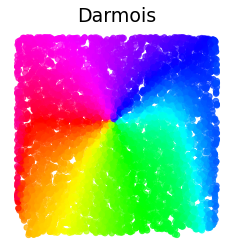

In [13]:
S_rec_darmois = inv_map_darmois.apply(params_darmois, None, X_test)
S_rec_uni_darmois = jnp.column_stack([jax.scipy.stats.norm.cdf(S_rec_darmois[:, 0]),
                              jax.scipy.stats.norm.cdf(S_rec_darmois[:, 1])])
S_rec_uni_darmois -= 0.5

scatterplot_variables(S_rec_uni_darmois, 'Reconstructed sources (test)',
                      colors=colors_test, cmap=cmap)

plt.title('Darmois', fontsize=19)

# Uncomment if you want to save the figure

# fname = os.path.join(figure_path, "darmois.pdf")
# plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)

plt.show()

### 4. Plot effects of a "Rotated-Gaussian" measure-preserving automorphism, with $\pi/4$ rotation

In [14]:
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c, -s], [s, c]])

measure_preserving, measure_preserving_inv = build_automorphism(R)
measure_preserving_batched = jax.vmap(measure_preserving)

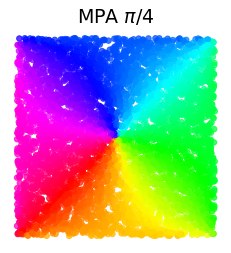

In [15]:
S_ = measure_preserving_batched(S_test + 0.5)

scatterplot_variables(S_, 'Mapped sources (test)',
                      colors=colors_test, cmap=cmap)


plt.title('MPA $\pi/4$', fontsize=19)

# Uncomment if you want to save the figure

# fname = os.path.join(figure_path, "mpa.pdf")
# plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)

plt.show()

### 5. Plot effects of the composition of the Darmois construction with a "Rotated-Gaussian" measure-preserving automorphism, with $\pi/4$ rotation

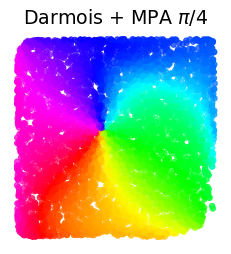

In [16]:
S_rec_uni_ = measure_preserving_batched(S_rec_uni_darmois + 0.5)

scatterplot_variables(S_rec_uni_, 'Reconstructed sources (test)',
                      colors=colors_test, cmap=cmap)

plt.title('Darmois + MPA $\pi/4$', fontsize=19)

# Uncomment if you want to save the figure

# fname = os.path.join(figure_path, "mpa_composed_darmois.pdf")
# plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)

plt.show()

### 6. Plotting the maximum likelihood learned model ($\lambda = 0$).

In [17]:
number_mle = '3308/'
model_root_mle = '/Users/luigigresele/Desktop/ICA and ICM/Experiments_Vincent/'+ number_mle

config_mle = get_config(model_root_mle + 'config/config.yaml')

In [18]:
params_mle = hk.data_structures.to_immutable_dict(jnp.load(model_root_mle + 'checkpoints/model_280000.npy', allow_pickle=True).item())

# Setup model
n_layers_mle = config_mle['model']['flow_layers']
hidden_units_mle = config_mle['model']['nn_layers'] * [config_mle['model']['nn_hidden_units']]

def inv_map_fn_mle(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_mle + [2], name='residual_' + str(i))
                           for i in range(n_layers_mle)] + [ConstantScaling(std_train)])
    return flows.inverse(x)

def fw_map_fn_mle(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_mle + [2], name='residual_' + str(i))
                           for i in range(n_layers_mle)] + [ConstantScaling(std_train)])
    return flows.forward(x)

fw_map_mle = hk.transform(fw_map_fn_mle)
inv_map_mle = hk.transform(inv_map_fn_mle)

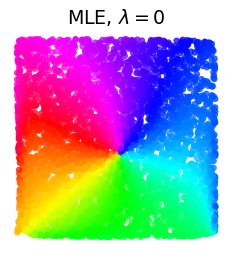

In [19]:
S_rec_mle = inv_map_mle.apply(params_mle, None, X_test)
S_rec_uni_mle = jnp.column_stack([jax.scipy.stats.logistic.cdf(S_rec_mle[:, 0]),
                              jax.scipy.stats.logistic.cdf(S_rec_mle[:, 1])])
S_rec_uni_mle -= 0.5

scatterplot_variables(S_rec_uni_mle, 'Reconstructed sources (test)',
                      colors=colors_test, cmap=cmap)

plt.title('MLE, $\lambda=0$', fontsize=19)

# Uncomment if you want to save the figure

# fname = os.path.join(figure_path, "mle.pdf")
# plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)

plt.show()

### 7. Plot reconstructed sources with $C_{\operatorname{IMA}}$ regularized model ($\lambda=1$).

In [20]:
number_cima = '0308_cima/0308/'
model_cima_root = '/Users/luigigresele/Desktop/ICA and ICM/Experiments_Vincent/'+ number_cima
config_cima = get_config(model_cima_root + 'config/config.yaml')

In [21]:
params_cima = hk.data_structures.to_immutable_dict(jnp.load(model_cima_root + 'checkpoints/model_300000.npy', allow_pickle=True).item())

In [22]:
# Setup model
n_layers_cima = config_cima['model']['flow_layers']
hidden_units_cima = config_cima['model']['nn_layers'] * [config_cima['model']['nn_hidden_units']]

def inv_map_fn_cima(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_cima + [2], name='residual_' + str(i))
                           for i in range(n_layers_cima)] + [ConstantScaling(std_train)])
    return flows.inverse(x)

def fw_map_fn_cima(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_cima + [2], name='residual_' + str(i))
                           for i in range(n_layers_cima)] + [ConstantScaling(std_train)])
    return flows.forward(x)

fw_map_cima = hk.transform(fw_map_fn_cima)
inv_map_cima = hk.transform(inv_map_fn_cima)

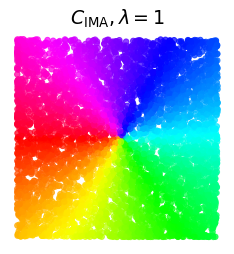

In [23]:
S_rec_cima = inv_map_cima.apply(params_cima, None, X_test)
S_rec_uni_cima = jnp.column_stack([jax.scipy.stats.logistic.cdf(S_rec_cima[:, 0]),
                              jax.scipy.stats.logistic.cdf(S_rec_cima[:, 1])])
S_rec_uni_cima -= 0.5

scatterplot_variables(S_rec_uni_cima, 'Reconstructed sources (test)',
                      colors=colors_test, cmap=cmap)


plt.title('$C_{\operatorname{IMA}}, \lambda=1$', fontsize=19)

# Uncomment if you want to save the figure

# fname = os.path.join(figure_path, "cima_model.pdf")
# plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format=None,
#             transparent=False, bbox_inches='tight', pad_inches=0.0,
#             frameon=None, metadata=None)

plt.show()